In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(50, 145, 96)

df = pd.read_csv('2017-03-16_PRO_single_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((96,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[15.32572674 16.98755721 14.92922972 15.3627439  15.02295244 15.705273
 15.98061325 15.04292525 15.63463783 15.39512585 15.04019614 15.19702602
 14.29895101 13.99206561 14.38686554 14.18405795 14.59272079 13.87176629
 13.84547218 13.22677587 13.70525082 12.75984326 11.1246528  12.24575028
 11.71324037 12.19549097 10.96459758 11.49398103 11.25370606 10.96118151
 10.58151218 11.45545721 10.69624233 10.95017808 10.19220781 10.58538615
 10.51537446 10.22496944  9.90517037  9.32207595  8.88697924  8.92342423
  8.70859346  8.74356335  8.34735886  8.43672922  8.13449445  7.9297604
  7.87692199  7.4515703   7.20122212  7.03228981  7.07821305  7.02640733
  6.26171702  6.73720268  6.33785453  6.24572654  5.94994958  5.63829762
  5.50464349  5.5429595   5.08550882  5.57763391  5.32845193  4.97532913
  4.99475725  5.04257871  5.15697586  4.26375421  4.32780545  4.19631982
  4.06540281  4.07352427  3.59727675  3.64048074  3.75307874  3.79019788
  3.6787362   3.34572862  3.24832264  3.13247506  3.23

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



ValueError: Values array must have shape `(n_times, n_outputs)`.

Create uniform log prior

In [ ]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.000001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 100
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_78676/1562655438.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [ ]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     492     0:01.3
2     1044    0:02.5
3     1515    0:03.7
20    8892    0:20.3
40    16071   0:37.1
60    22740   0:53.1
80    29127   1:08.6
100   35697   1:24.7
120   42375   1:40.7
140   49035   1:56.7
160   55839   2:13.1
180   62667   2:29.5
200   69474   2:45.8
220   76371   3:02.3
240   83214   3:18.8
260   89931   3:35.1
280   96738   3:51.6
300   103521   4:08.1
320   110472   4:24.9
340   117579   4:41.8
360   124665   4:59.0
380   131529   5:15.6
400   138078   5:31.5
420   144906   5:47.7
440   152058   6:04.8
460   158817   6:21.0
480   165729   6:37.6
500   172605   6:54.0
520   179070   7:09.6
540   186048   7:26.3
560   192834   7:42.6
580   199743   7:59.2
600   206682   8:15.8
620   213387   8:32.0
640   219933   8:47.9
660   226557   9:03.9
680   233718   9:21.0
700   240663   9:37.8
720   247635   9:54.6
740   254652  10:11.3
760   261405  

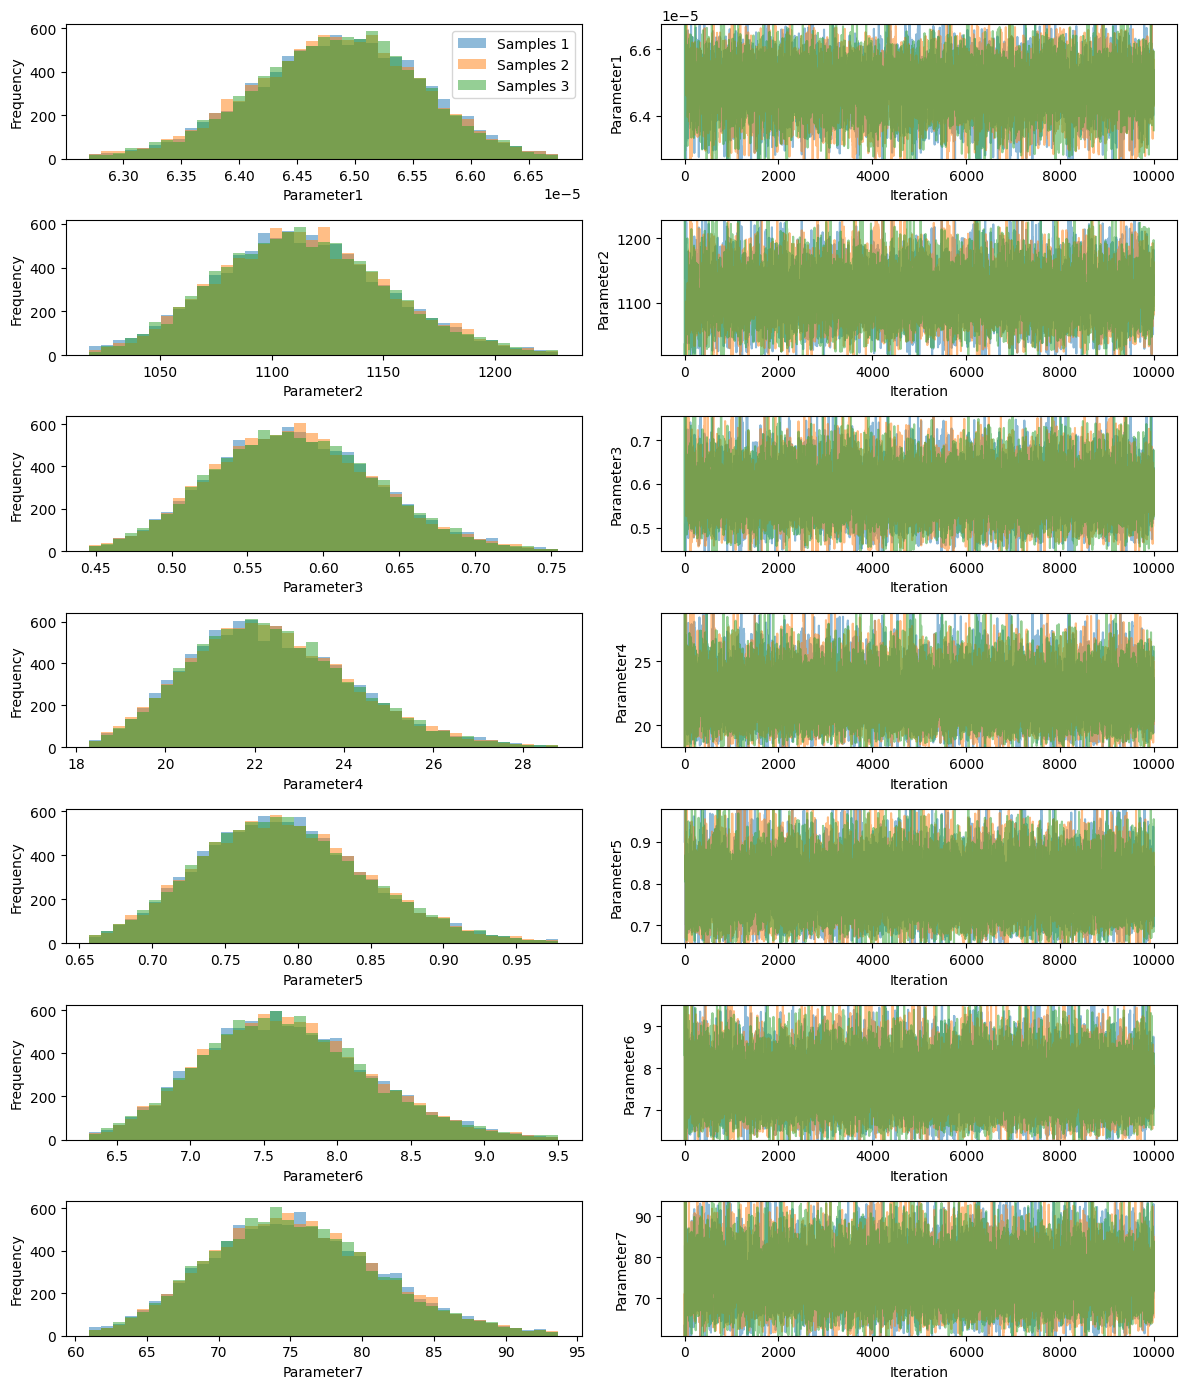

In [ ]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [ ]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 7)
[6.51340192e-05 1.12114404e+03 5.61960622e-01 2.18997166e+01
 6.89940204e-01 7.43121894e+00 7.42454137e+01]
[[6.51340192e-05 1.12114404e+03 5.61960622e-01 ... 6.89940204e-01
  7.43121894e+00 7.42454137e+01]
 [6.44331672e-05 1.12793329e+03 5.25804864e-01 ... 7.57807867e-01
  8.32702832e+00 7.59384398e+01]
 [6.44968623e-05 1.14880247e+03 5.92182425e-01 ... 7.55175337e-01
  7.62499748e+00 7.33571527e+01]
 ...
 [6.51935896e-05 1.12417293e+03 5.90858035e-01 ... 7.36853123e-01
  8.00080420e+00 7.76309206e+01]
 [6.51138066e-05 1.11209271e+03 5.78838475e-01 ... 7.89110922e-01
  7.53087148e+00 7.19440048e+01]
 [6.46303486e-05 1.12243760e+03 5.31607584e-01 ... 7.58023148e-01
  7.43595068e+00 7.44637727e+01]]


In [ ]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


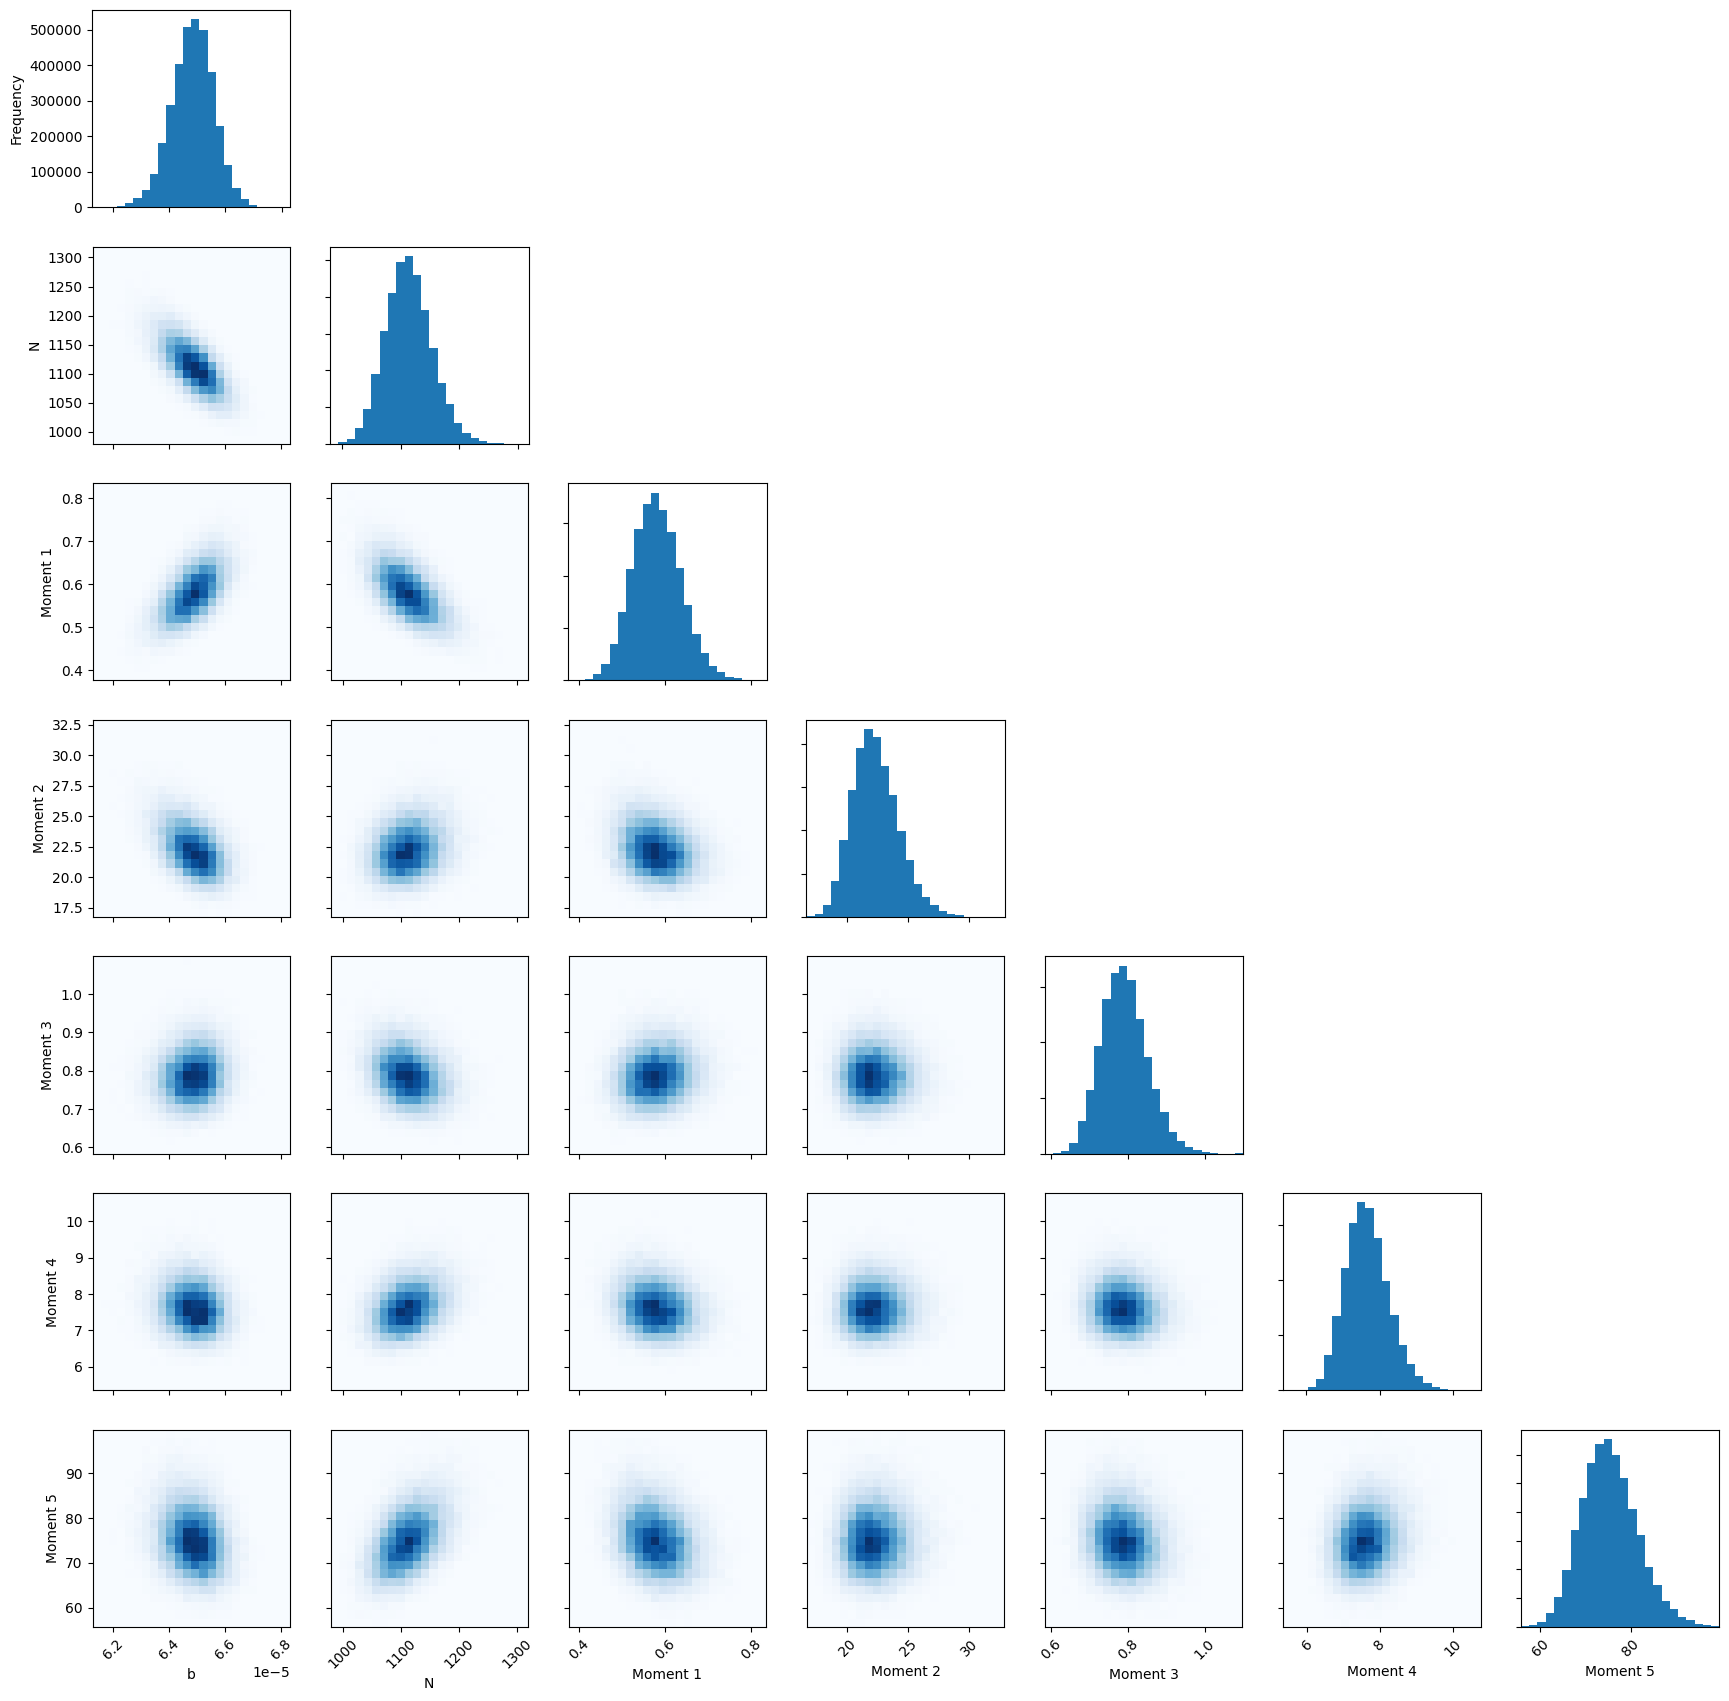

In [ ]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

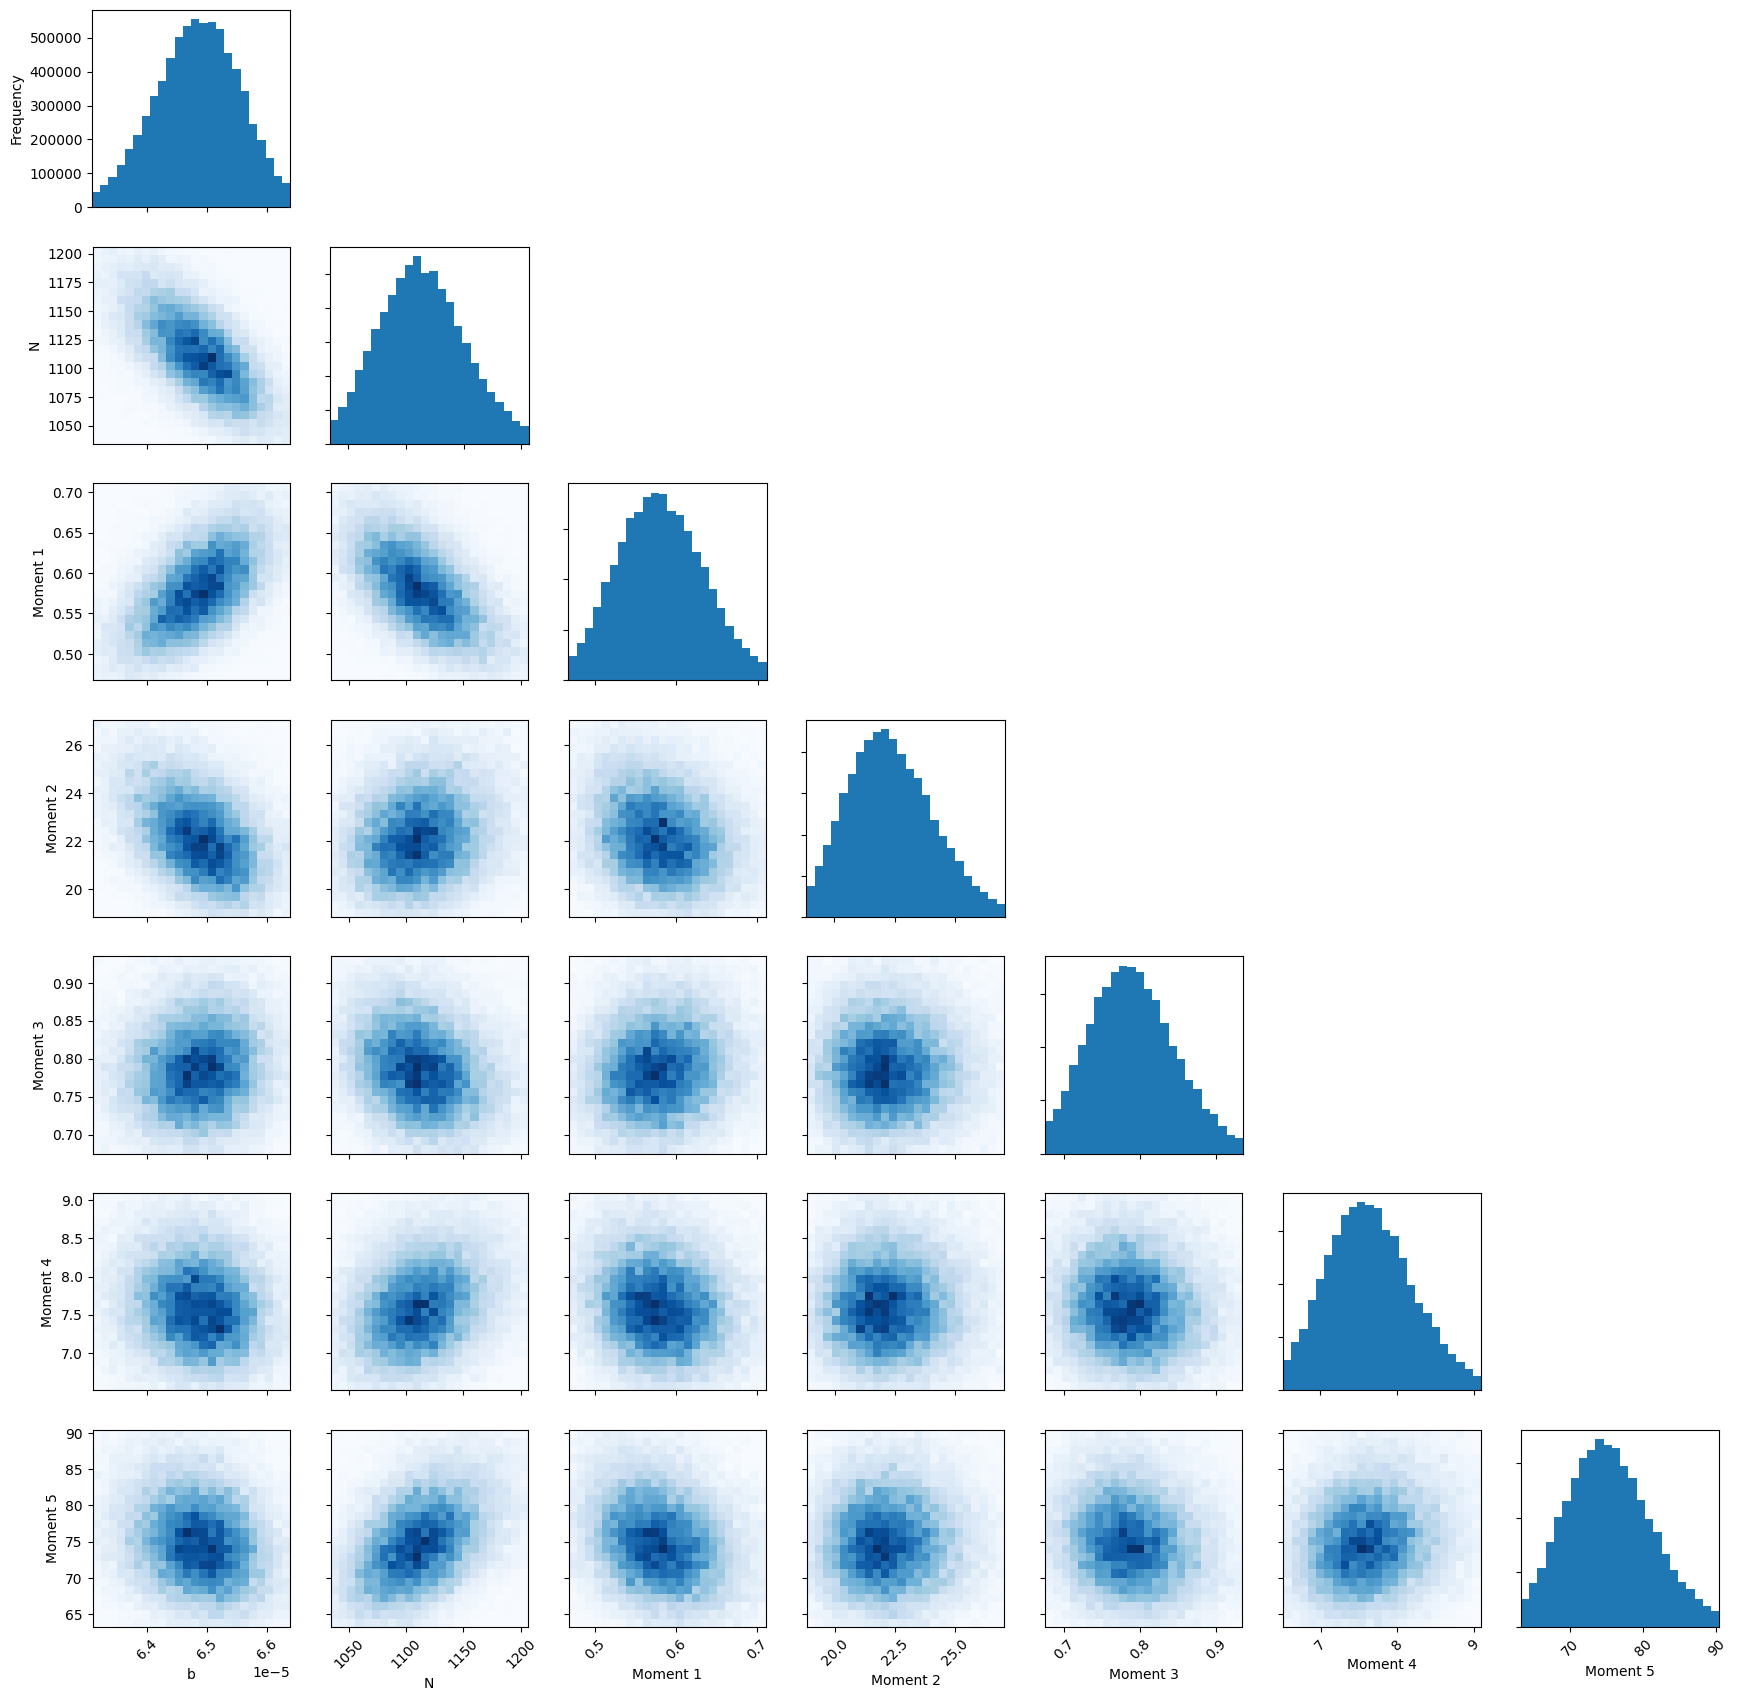

In [ ]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[6.51340192e-05 1.12114404e+03 5.61960622e-01 2.18997166e+01
 6.89940204e-01 7.43121894e+00 7.42454137e+01]


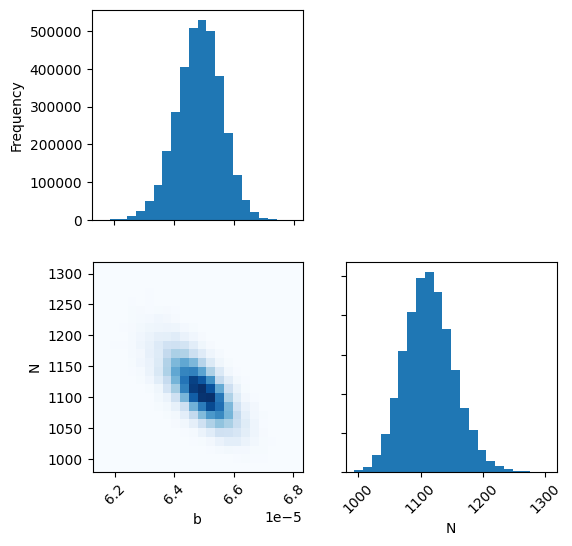

In [ ]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise_pro_params_only.png", dpi =300)
plt.show()


In [ ]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    1862.02  0.23
N         1114.73  39.17   1042.37  1087.61  1112.90  1139.81  1196.64  1.00    1797.31  0.22
Moment 1  0.58     0.06    0.48     0.54     0.58     0.62     0.70     1.00    2222.35  0.28
Moment 2  22.38    1.89    19.12    21.04    22.22    23.57    26.42    1.00    3386.76  0.42
Moment 3  0.79     0.06    0.68     0.75     0.79     0.83     0.92     1.00    4492.00  0.56
Moment 4  7.66     0.59    6.61     7.25     7.63     8.03     8.94     1.00    4274.01  0.53
Moment 5  75.43    6.18    64.36    71.15    75.07    79.43    88.50    1.00    3147.75  0.39


In [ ]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [ ]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         6.48e-05  7.46e-07  6.33e-05  6.43e-05  6.48e-05  6.53e-05  6.62e-05  1       1.86e+03  0.232
N         1.11e+03  39.2      1.04e+03  1.09e+03  1.11e+03  1.14e+03  1.2e+03   1       1.8e+03   0.224
Moment 1  0.581     0.0557    0.478     0.542     0.579     0.617     0.697     1       2.22e+03  0.277
Moment 2  22.4      1.89      19.1      21        22.2      23.6      26.4      1       3.39e+03  0.422
Moment 3  0.79      0.0586    0.684     0.749     0.786     0.826     0.916     1       4.49e+03  0.56
Moment 4  7.66      0.594     6.61      7.25      7.63      8.03      8.94      1       4.27e+03  0.533
Moment 5  75.4      6.18      64.4      71.2      75.1      79.4      88.5      1       3.15e+03  0.393


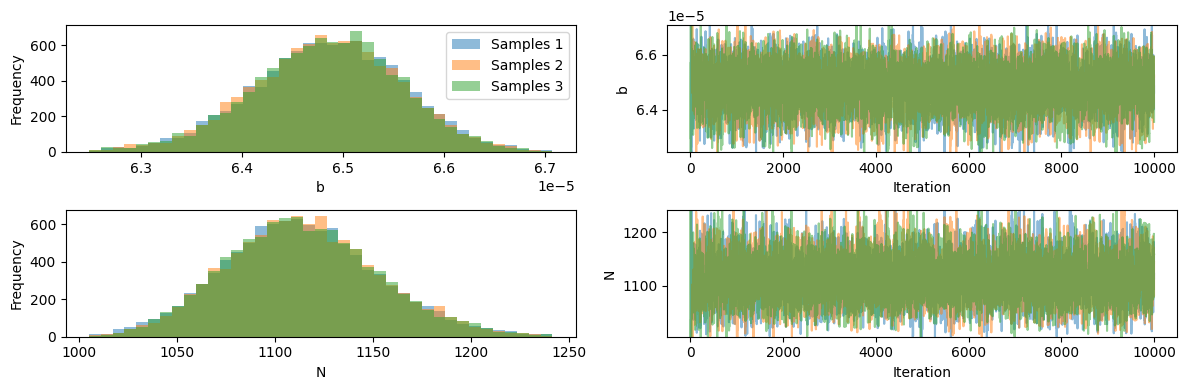

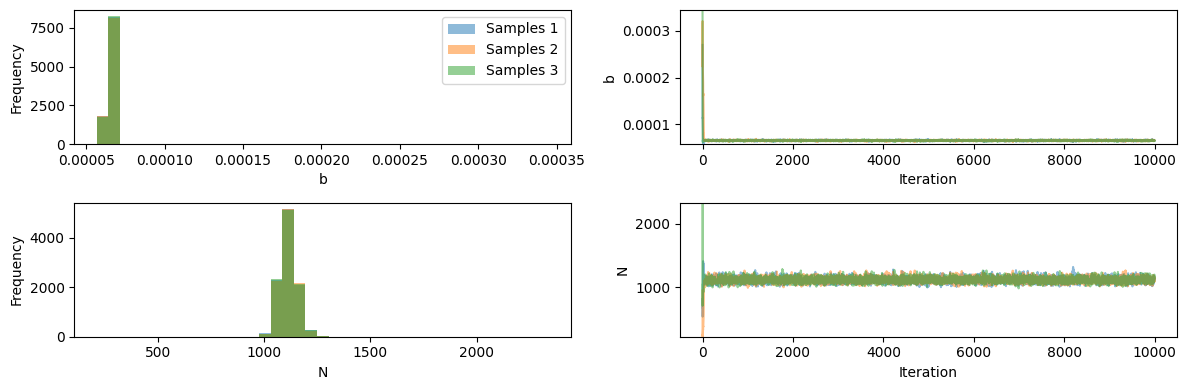

In [ ]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()